In [1]:
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import drjit as dr 
from matplotlib import pyplot as plt
from PDE3D import PATH
import numpy as np
from PDE3D.BoundaryShape import *
from PDE3D.utils import *
import os
import numpy as np
from PDE3D.Coefficient import *
from PDE3D.Solver import *

In [2]:
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import drjit as dr 
from matplotlib import pyplot as plt
from PDE3D import PATH
import numpy as np
from PDE3D.BoundaryShape import *
from PDE3D.utils import *
import os
import numpy as np
from PDE3D.Coefficient import *
from PDE3D.Solver import *

In [3]:
name = "motorbike-engine"
solution_resolution = [128,128,4]
res_slice = [512, 512]
folder_name = os.path.join(PATH, "scenes", name)
xml_name = os.path.join(folder_name, "scene.xml")
sdf_data = np.load(os.path.join(folder_name, "sdf.npy"))
spp = 64
downsample = 1
sdf_data = sdf_data[::downsample,::downsample,::downsample]
cam_origin = mi.ScalarPoint3f([7.8,7,20])
scale_cam = 0.28
cam_target = mi.ScalarPoint3f([0,-0.1,-0.2])
cam_up = mi.ScalarPoint3f([0,1,0])
cam_res = [1024, 1024]

slice = Slice(offset =0, scale = 7, axis = "z")
cmap = "viridis"
sym = False

In [4]:
def dirichlet(points, params):
    return dr.sin(points[0] * params["x"]) + dr.cos(points[1] * points[2] * params["yz"])
params1 = {}
params1["x"] = 0.2
params1["yz"] = 0.4

params2 = {}
params2["x"] = 4
params2["yz"] = 0.4

boundary_cond1 = FunctionCoefficient("dirichlet", params1, dirichlet)
boundary_cond2 = FunctionCoefficient("dirichlet", params2, dirichlet)
boundary_cond3 = ConstantCoefficient("dirichlet", 0)

In [5]:
sdf = SDF(sdf_data, mesh_scene_xml=xml_name, dirichlet = [boundary_cond3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8505064].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8505064].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8505064].


Text(0.5, 1.0, 'Boundary Condition')

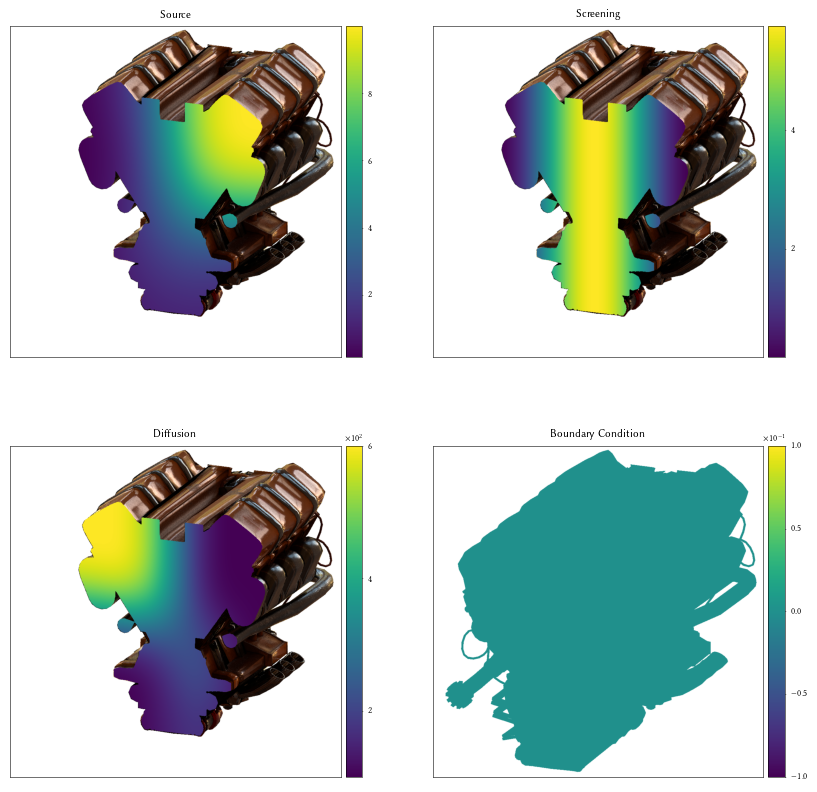

In [6]:
source = np.array([[0,0,0,0],
                  [1,2,1,2],
                  [1,3,10,10],
                  [1,1,10,10]])
source = source[:,:,np.newaxis]

screening = np.array([[0,0,0,0],
                      [6,6,6,6],
                      [6,6,6,6],
                      [0,0,0,0]])
screening = screening[:,:,np.newaxis]

diffusion = np.array([[1,1,6,6],
                      [1,1,6,6],
                      [2,3,1,1],
                      [1,1,1,1]]) * 100
diffusion = diffusion[:,:,np.newaxis]

bbox = sdf.mesh_scene.bbox()
bbox_pad = (bbox.max - bbox.min) / 10
bbox_coeff = mi.ScalarBoundingBox3f(bbox.min - bbox_pad, bbox.max + bbox_pad)
f = TextureCoefficient("source", bbox_coeff, source)
#f = ConstantCoefficient("a", 0)
σ = TextureCoefficient("screening", bbox, screening)
α = TextureCoefficient("diffusion", bbox, diffusion)

points, _ = slice.create_slice_points(resolution = res_slice, spp = 1, centered = True)
f_vals = f.get_value(points)
σ_vals = σ.get_value(points)
α_vals = α.get_value(points)

#f_image, f_tensor = create_slice_from_result(result = f_vals, resolution = res_slice)
#σ_image, σ_tensor = create_slice_from_result(result = σ_vals, resolution = res_slice)
#α_image, α_tensor = create_slice_from_result(result = α_vals, resolution = res_slice)

f3D, f_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=f)
σ3D, σ_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff=σ)
α3D, α_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff= α)

dirichlet3D, dirichlet_norm = sdf.visualize(colormap = cmap, cam_origin= cam_origin, spp = spp, image_res = cam_res, 
                            scale_cam=scale_cam, cam_up = cam_up,cam_target = cam_target, conf_number=0)

fig, ax = plt.subplots(2,2, figsize = (10,10))

plot_image_3D(f3D, ax[0,0], norm = f_norm, cmap = cmap)
plot_image_3D(σ3D, ax[0,1], norm = σ_norm, cmap = cmap)
plot_image_3D(α3D, ax[1,0], norm = α_norm, cmap = cmap)
plot_image_3D(dirichlet3D, ax[1,1], norm = dirichlet_norm, cmap = cmap)

ax[0,0].set_title("Source")
ax[0,1].set_title("Screening")
ax[1,0].set_title("Diffusion")
ax[1,1].set_title("Boundary Condition")

In [7]:
data_holder = DataHolder(f=f, σ=σ, α=α, shape = sdf)
wos = WosVariable(input=data_holder, max_z = 5)
spp_low = 64
spp_high = 256
bbox = sdf.bbox
bbox_pad = (bbox.max - bbox.min) / 10
bbox_ = mi.ScalarBoundingBox3f(bbox.min - bbox_pad, bbox.max + bbox_pad)

points_low = create_bbox_points(bbox_, resolution = solution_resolution, spp = spp_low, centered=True)
points_high = create_bbox_points(bbox_, resolution = solution_resolution, spp = spp_high, centered=True)
L_low, _ = wos.solve(points_low, split = Split.Normal, conf_numbers=[mi.UInt32[0]])
L_high, _ = wos.solve(points_high, split = Split.Normal, conf_numbers=[mi.UInt32[0]])
sol_low, _ = create_volume_from_result(L_low, solution_resolution)
sol_high, _ = create_volume_from_result(L_high, solution_resolution)


0 : 4194304 -> 3943
1 : 3943 -> 120
2 : 120 -> 5
3 : 5 -> 0
0 : 16777216 -> 15711
1 : 15711 -> 493
2 : 493 -> 19
3 : 19 -> 0


In [20]:
def visualize_tensor(ax, shape, tensor, slice : Slice, nearest = False, cmap = "Reds", input_range = None, delete_left_ratio = 1, sym = False):
    interpolation = "nearest" if nearest else "cubic"
    bbox = sdf.bbox
    bbox_pad = (bbox.max - bbox.min) / 10
    bbox_coeff = mi.ScalarBoundingBox3f(bbox.min - bbox_pad, bbox.max + bbox_pad)

    coeff = TextureCoefficient(name = "coeff", bbox = bbox_coeff, tensor_np = tensor.squeeze(), interpolation=interpolation)
    coeff3D, coeffnorm = shape.visualize(colormap = cmap, cam_origin= cam_origin, spp = 512, image_res = cam_res, 
                                          scale_cam=scale_cam, cam_up = cam_up, slice = slice, cam_target = cam_target, coeff= coeff, input_range = input_range, sym_colorbar = sym)
    ny = coeff3D.shape[1]
    coeff3D = coeff3D[:, int(-delete_left_ratio * ny):, :]
    plot_image_3D(coeff3D, ax, cmap = cmap)
    disable_border(ax)
    disable_ticks(ax)
    return coeffnorm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8550763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8550763].


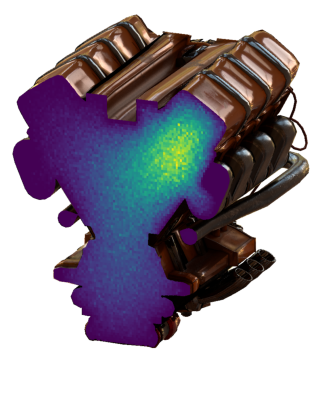

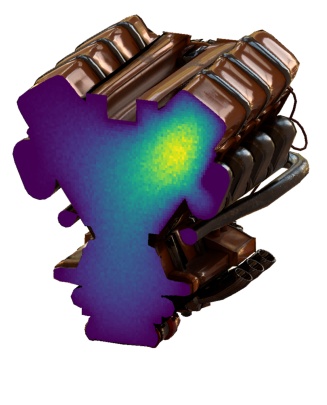

In [22]:
fig, (ax1) = plt.subplots(1,1, figsize = (5,5))
slice = Slice(offset =0.0, scale = 7, axis = "z")
visualize_tensor(ax1, sdf, sol_low[0], slice, nearest =True, cmap = "viridis", delete_left_ratio=0.8)
plt.savefig("var1.png", bbox_inches='tight', pad_inches=0.04, dpi=500)
fig, (ax2) = plt.subplots(1,1, figsize = (5,5))
slice = Slice(offset =0.0, scale = 7, axis = "z")
visualize_tensor(ax2, sdf, sol_high[0], slice, nearest =True, cmap = "viridis", delete_left_ratio=0.8)
plt.savefig("var2.png", bbox_inches='tight', pad_inches=0.04, dpi=500)
